# Analyze geolocation per timeunit

In [152]:
import os
import math

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

dir_in = './data_ori/'

ERROR! Session/line number was not unique in database. History logging moved to new session 258


In [153]:

def age_group(sex, age):
    # Convert age column to age group
    #ageGroupsF = ['23-','24-26','27-28','29-32','33-42,''43+']
    #ageGroupsM = ['22-','23-26','27-28','29-31','32-38,''39+']

    if sex not in ['M','F']:
        ValueError('%s is not a valid gender' % sex)
        
    if age not in range(100):
        ValueError('%s is not a valid age' % age)
    
    if sex=="M":
        if age<=22:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=31:
            g = 3
        elif age<=38:
            g = 4
        else:
            g = 5
    elif sex=="F":
        if age<=23:
            g = 0
        elif age<=26:
            g = 1
        elif age<=28:
            g = 2
        elif age<=32:
            g = 3
        elif age<=42:
            g = 4
        else:
            g = 5
    
    return g
train = pd.read_csv('./data_ori/' + 'gender_age_train.csv', index_col='device_id')
train['age_group'] = train[['gender','age']].apply(lambda x: age_group(x[0],x[1]), axis=1)
train.drop(['age','group'], axis=1, inplace=True)

events = pd.read_csv(dir_in + 'events.csv')
events['timestamp'] = pd.to_datetime(events['timestamp'])
events['timestamp_h'] = events['timestamp'].dt.hour
events['timestamp_d'] = events['timestamp'].dt.day

In [154]:
train_0 = events[(events.longitude>0) & (events.latitude>0)].groupby('device_id').first()
train_0.head()

,event_id,timestamp,longitude,latitude,timestamp_h,timestamp_d
device_id,,,,,,
-9222956879900151005,12679,2016-05-07 12:18:35,113.24,23.19,12,7
-9221825537663503111,74539,2016-05-07 07:52:34,113.36,33.63,7,7
-9221026417907250887,6402,2016-05-02 07:56:49,114.36,30.87,7,2
-9220452176650064280,105475,2016-05-06 08:19:24,1.00,1.00,8,6
-9220061629197656378,279922,2016-05-05 13:08:11,124.90,46.60,13,5


## Check differences weekend/weekday

In [155]:
weekdays = [2,3,4,5,6]
weekends = [30,1,7,8]
events['weekend'] = events.timestamp_d.isin(weekends).astype(int)

In [156]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,timestamp_h,timestamp_d,weekend
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,1,1
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0,1,1
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,0,1,1
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,0,1,1
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,0,1,1


In [157]:
df = events.groupby(['device_id','weekend'])['longitude','latitude'].mean().unstack('weekend').fillna(0)

In [158]:
df.head()

longitude               latitude           
weekend                        0           1          0          1
device_id                                                         
-9222956879900151005   98.141333   84.121143  20.098000  17.226857
-9222661944218806987    0.000000    0.000000   0.000000   0.000000
-9222399302879214035    0.000000    0.000000   0.000000   0.000000
-9221825537663503111  111.670923  113.505000  33.424923  34.689118
-9221767098072603291    0.000000    0.000000   0.000000   0.000000

In [159]:
diff_lon = abs(df['longitude'][0] - df['longitude'][1])
diff_lan = abs(df['latitude'][0] - df['latitude'][1])

In [160]:
diff_lon.shape

(60865,)

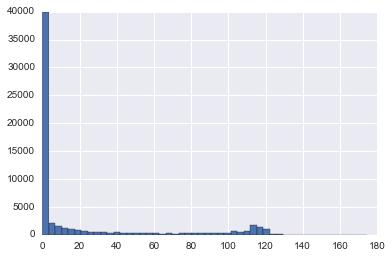

In [161]:
diff_lon.hist(bins=50)

## Validation

In [256]:
df = pd.merge(events, train, how='inner', left_on='device_id', right_index=True)
df = df[(df.longitude>0) & (df.latitude>0)]

In [257]:
df.shape

(858777, 10)

In [260]:
events.shape

(3252950, 8)

In [261]:
train.shape

(74645, 2)

In [262]:
df['weekend'] = df.timestamp_d.isin(weekends).astype(int)
df.head()

,event_id,device_id,timestamp,longitude,latitude,timestamp_h,timestamp_d,weekend,gender,age_group
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,1,1,M,5
7103,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,9,2,0,M,5
29660,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,0,4,0,M,5
33132,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,5,6,0,M,5
38979,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,9,6,0,M,5


In [284]:
df2 = df.groupby(['device_id','weekend','gender'])['longitude','latitude'].mean().unstack('weekend').fillna(0)
df2.head()

longitude               latitude           
weekend                               0           1          0          1
device_id            gender                                              
-9222956879900151005 M       113.240000  113.240000  23.190000  23.190000
-9221026417907250887 F       114.361398  114.364615  30.871720  30.871026
-9220061629197656378 M       124.885294  124.910000  46.621765  46.600000
-9218769147970107256 M       112.333529    0.000000  28.582353   0.000000
-9215352913819638805 M       114.020000    0.000000  22.660000   0.000000

In [285]:
diff_lon = abs(df2['longitude'][0] - df2['longitude'][1]).reset_index()
diff_lat = abs(df2['latitude'][0] - df2['latitude'][1]).reset_index()

In [286]:
diff_lat.head()

,device_id,gender,0
0,-9222956879900151005,M,0.000000
1,-9221026417907250887,F,0.000695
2,-9220061629197656378,M,0.021765
3,-9218769147970107256,M,28.582353
4,-9215352913819638805,M,22.660000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1bdf5cd50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x2021f5cd0>], dtype=object)

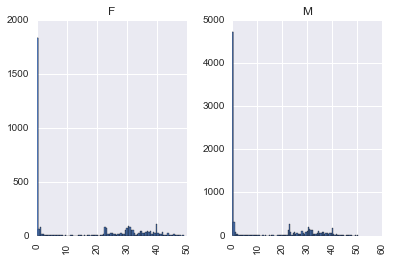

In [290]:
diff_lat[['gender',0]].hist(by='gender', bins=100)

In [291]:
diff_lat[diff_lat[0]>5].head()

,device_id,gender,0
3,-9218769147970107256,M,28.582353
4,-9215352913819638805,M,22.660000
5,-9212424538588397592,F,22.950000
9,-9201141107731295908,F,39.854583
10,-9200975789875358770,M,21.869000


In [293]:
print diff_lat[diff_lat[0]>1].groupby('gender').mean()
print diff_lon[diff_lon[0]>1].groupby('gender').mean()

                 device_id          0
gender                               
F       -55218068048895808  30.499451
M      -105204980551530416  28.996280
                device_id           0
gender                               
F      -75903015407677552  105.508693
M      -86770696427822832  101.585105


In [294]:
df2 = df.groupby(['device_id','weekend','age_group'])['longitude','latitude'].mean().unstack('weekend').fillna(0)
df2.head()

longitude               latitude           
weekend                                  0           1          0          1
device_id            age_group                                              
-9222956879900151005 4          113.240000  113.240000  23.190000  23.190000
-9221026417907250887 3          114.361398  114.364615  30.871720  30.871026
-9220061629197656378 5          124.885294  124.910000  46.621765  46.600000
-9218769147970107256 1          112.333529    0.000000  28.582353   0.000000
-9215352913819638805 0          114.020000    0.000000  22.660000   0.000000

In [295]:
diff_lon = abs(df2['longitude'][0] - df2['longitude'][1]).reset_index()
diff_lat = abs(df2['latitude'][0] - df2['latitude'][1]).reset_index()

In [307]:
print diff_lat[diff_lat[0]>=0].groupby('age_group').mean()
print diff_lon[diff_lon[0]>=0].groupby('age_group').mean()

                    device_id          0
age_group                               
0         -104192233374878576  14.593221
1         -125563070228127136  13.195062
2          -31476681447670376  12.792778
3          -44303525340449704  12.483271
4           80351369141966416  11.645844
5          -70739520684102592  10.593637
                    device_id          0
age_group                               
0         -104192233374878576  52.420052
1         -125563070228127136  47.906006
2          -31476681447670376  46.020262
3          -44303525340449704  44.703429
4           80351369141966416  41.429000
5          -70739520684102592  37.168278


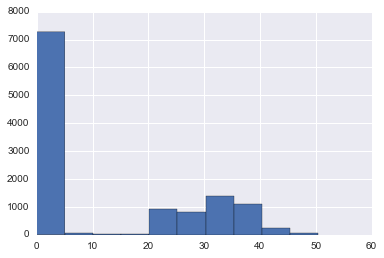

In [299]:
diff_lat[0].hist()

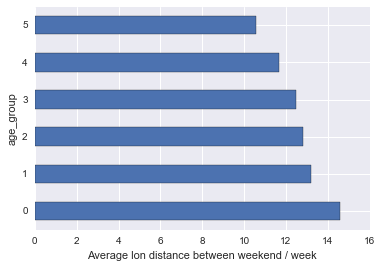

In [300]:
diff_lat.groupby('age_group').mean()[0].plot(kind='barh')
plt.xlabel('Average lon distance between weekend / week')

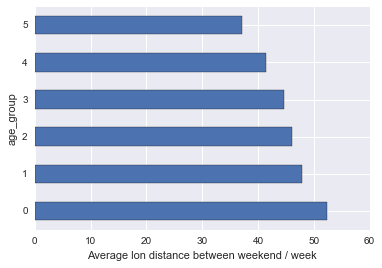

In [301]:
diff_lon.groupby('age_group').mean()[0].plot(kind='barh')
plt.xlabel('Average lon distance between weekend / week')

## Comparison working hours & other

In [245]:
home = [0,1,2,3,4,5,6] + [19,20,21,22,23] 
work = [7,8,9,10,11] + [12,13,14,15,16,17,18]
df['home'] = df.timestamp_h.isin(home).astype(int)

In [246]:
print df.shape
print float(sum(df.home==1)) / df.shape[0]
df.head()

(858777, 11)
0.415970618682


,event_id,device_id,timestamp,longitude,latitude,timestamp_h,timestamp_d,weekend,gender,age_group,home
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,1,1,M,5,1
7103,7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,9,2,0,M,5,0
29660,29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,0,4,0,M,5,1
33132,33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,5,6,0,M,5,1
38979,38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,9,6,0,M,5,0


In [247]:
df2 = df.groupby(['device_id','home','gender'])['longitude','latitude'].mean().unstack('home').fillna(0)
df2.head()

longitude              latitude          
home                                  0          1          0         1
device_id            gender                                            
-9222956879900151005 M       113.240000  113.24000  23.190000  23.19000
-9221026417907250887 F       114.363133  114.36102  30.871807  30.87102
-9220061629197656378 M       124.887297  124.91000  46.620000  46.60000
-9218769147970107256 M       112.340000  112.33000  28.550000  28.60000
-9215352913819638805 M       114.020000    0.00000  22.660000   0.00000

In [248]:
diff_lon = abs(df2['longitude'][0] - df2['longitude'][1]).reset_index()
diff_lat = abs(df2['latitude'][0] - df2['latitude'][1]).reset_index()
diff_lon.head()

,device_id,gender,0
0,-9222956879900151005,M,8.526513e-14
1,-9221026417907250887,F,2.112122e-03
2,-9220061629197656378,M,2.270270e-02
3,-9218769147970107256,M,1.000000e-02
4,-9215352913819638805,M,1.140200e+02


In [249]:
print diff_lat.groupby('gender').mean()
print diff_lon.groupby('gender').mean()

                device_id          0
gender                              
F      -18476500057124584  12.918971
M      -51105419262692144  10.956222
                device_id          0
gender                              
F      -18476500057124584  45.305002
M      -51105419262692144  39.717603


### Conclusion: hardly any difference per gender

In [251]:
df2 = df.groupby(['device_id','home','age_group'])['longitude','latitude'].mean().unstack('home').fillna(0)
df2.head()

longitude              latitude          
home                                     0          1          0         1
device_id            age_group                                            
-9222956879900151005 4          113.240000  113.24000  23.190000  23.19000
-9221026417907250887 3          114.363133  114.36102  30.871807  30.87102
-9220061629197656378 5          124.887297  124.91000  46.620000  46.60000
-9218769147970107256 1          112.340000  112.33000  28.550000  28.60000
-9215352913819638805 0          114.020000    0.00000  22.660000   0.00000

In [252]:
diff_lon = abs(df2['longitude'][0] - df2['longitude'][1]).reset_index()
diff_lat = abs(df2['latitude'][0] - df2['latitude'][1]).reset_index()
diff_lon.head()

,device_id,age_group,0
0,-9222956879900151005,4,8.526513e-14
1,-9221026417907250887,3,2.112122e-03
2,-9220061629197656378,5,2.270270e-02
3,-9218769147970107256,1,1.000000e-02
4,-9215352913819638805,0,1.140200e+02


In [253]:
print diff_lat.groupby('age_group').mean()
print diff_lon.groupby('age_group').mean()

                    device_id          0
age_group                               
0         -104192233374878576  14.296152
1         -125563070228127136  12.236211
2          -31476681447670376  11.854597
3          -44303525340449704  11.475766
4           80351369141966416  10.761430
5          -70739520684102592   9.773309
                    device_id          0
age_group                               
0         -104192233374878576  51.482848
1         -125563070228127136  44.629450
2          -31476681447670376  43.042787
3          -44303525340449704  40.920736
4           80351369141966416  38.588538
5          -70739520684102592  34.111341


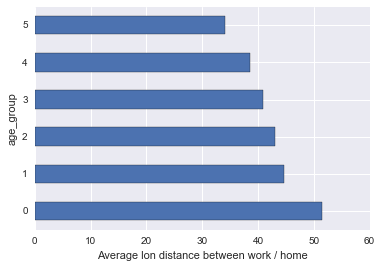

In [254]:
diff_lon.groupby('age_group').mean()[0].plot(kind='barh')
plt.xlabel('Average lon distance between work / home')

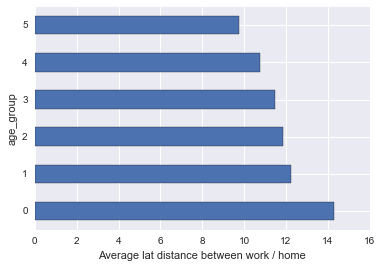

In [255]:
diff_lat.groupby('age_group').mean()[0].plot(kind='barh')
plt.xlabel('Average lat distance between work / home')